In [80]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer, SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.decomposition import PCA


#import knn classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score, accuracy_score

# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras import regularizers
# from keras import initializers
# from keras.layers import BatchNormalization
# from tensorflow.keras.constraints import MaxNorm
# from kerastuner.tuners import Hyperband

# from tensorflow.keras.optimizers import Adam

# import shap
# from lime import lime_tabular


In [81]:
train = pd.read_csv('data/train.csv')
train2 = pd.read_csv('data/training_extra.csv')
test = pd.read_csv('data/test.csv')


In [82]:
train = pd.concat([train, train2], axis=0)
train.reset_index(inplace=True, drop=True)
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


### Encode Categories

In [83]:
train.shape

(3994318, 11)

In [84]:
cat_cols = ['Brand', 'Material', 'Size', 'Style', 'Color', 'Laptop Compartment', 'Waterproof']

# fill na with 'Unknown'

for col in cat_cols:
    train[col] = train[col].fillna('Unknown')
    test[col] = test[col].fillna('Unknown')


# encode the categorical columns using one-hot encoding

train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)



In [85]:
train.shape

(3994318, 29)

### Feature Imputation

In [86]:
train.columns

Index(['id', 'Compartments', 'Weight Capacity (kg)', 'Price', 'Brand_Jansport',
       'Brand_Nike', 'Brand_Puma', 'Brand_Under Armour', 'Brand_Unknown',
       'Material_Leather', 'Material_Nylon', 'Material_Polyester',
       'Material_Unknown', 'Size_Medium', 'Size_Small', 'Size_Unknown',
       'Style_Messenger', 'Style_Tote', 'Style_Unknown', 'Color_Blue',
       'Color_Gray', 'Color_Green', 'Color_Pink', 'Color_Red', 'Color_Unknown',
       'Laptop Compartment_Unknown', 'Laptop Compartment_Yes',
       'Waterproof_Unknown', 'Waterproof_Yes'],
      dtype='object')

In [87]:
print(train.isna().sum().sum())

num_cols = [col for col in train.columns if train[col].dtype in ['float64', 'int64']]
num_cols.remove('Price')

for col in num_cols:
    train.fillna({col:train[col].mean()}, inplace=True)
    test.fillna({col:test[col].mean()}, inplace=True)
print(train.isna().sum().sum())

1808
0


### Feature Engineering 

In [88]:
def engineer_features(df):

    df['weight_capacity_rounded'] = df['Weight Capacity (kg)'].apply(lambda x: round(x))
    
    binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
    binned_values = binner.fit_transform(df[['weight_capacity_rounded']]).astype(int).flatten()

    # Create bin category column
    bin_col_name = f"weight_capacity_bins"
    df[bin_col_name] = binned_values

    df['weight_capacity_ratio'] = df['Weight Capacity (kg)'] / df['Weight Capacity (kg)'].max()

    df['weight_capacity_squared'] = df['Weight Capacity (kg)'] ** 2

    df['weight_capacity_cubed'] = df['Weight Capacity (kg)'] ** 3

    df['weight_to_compartments'] = df['Weight Capacity (kg)'] / (df['Compartments'] + 1)

    df['compartments_bins'] = pd.cut(df['Compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Very Many'])
    df['compartments_bins'] = df['compartments_bins'].astype('category').cat.codes

    columns = [col.lower() for col in df.columns]
    df.columns = columns

    df = df.rename(columns={'weight capacity (kg)':'weight_capacity'})

    return df 

train = engineer_features(train)
test = engineer_features(test)



### Target Encoding

In [89]:
te_cols = ['compartments', 'weight_capacity', 'weight_capacity_rounded',
       'weight_capacity_bins', 'weight_capacity_ratio',
       'weight_capacity_squared', 'weight_capacity_cubed',
       'weight_to_compartments', 'compartments_bins']

new_feature_cols = [feature + '_te' for feature in te_cols]

In [90]:

# Initialize KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for col in te_cols:
    print(col)
    # Create a new column to store the encoded values
    train[col + '_te'] = np.nan

    # Out-of-fold target encoding
    for train_idx, val_idx in kf.split(train):
        # Split data
        train_set, val_set = train.iloc[train_idx], train.iloc[val_idx]
        
        # Calculate category means on training data
        category_means = train_set.groupby(col)['price'].mean()
        
        # Encode validation fold using category means from the training fold
        train.loc[val_idx, col + '_te'] = train.loc[val_idx, col].map(category_means)

    # Fill any NaN values with the overall mean target
    overall_mean = train[col].mean()
    
    train.fillna({col + '_te':overall_mean}, inplace=True)  # Fill any NaN values with the overall mean target 

    final_category_means = train.groupby(col)['price'].mean()

    # Map the test set categories using the train set means
    test[col + '_te'] = test[col].map(final_category_means)

    # Fill NaN values in the test set with the overall mean
    test.fillna({col + '_te':overall_mean}, inplace=True)

compartments
weight_capacity
weight_capacity_rounded
weight_capacity_bins
weight_capacity_ratio
weight_capacity_squared
weight_capacity_cubed
weight_to_compartments
compartments_bins


In [ ]:
# encoder = TargetEncoder(cols=te_cols)

# train[new_feature_cols] = None
# train[new_feature_cols] = encoder.fit_transform(train[te_cols], train['price'])

# test[new_feature_cols] = None
# test[new_feature_cols] = encoder.transform(test[te_cols])

### Scaling

In [91]:
feature_cols = [col for col in train.columns if col not in ['id', 'price']]


In [92]:
scaler = StandardScaler()

train[feature_cols] = scaler.fit_transform(train[feature_cols])
test[feature_cols] = scaler.transform(test[feature_cols])

### PCA

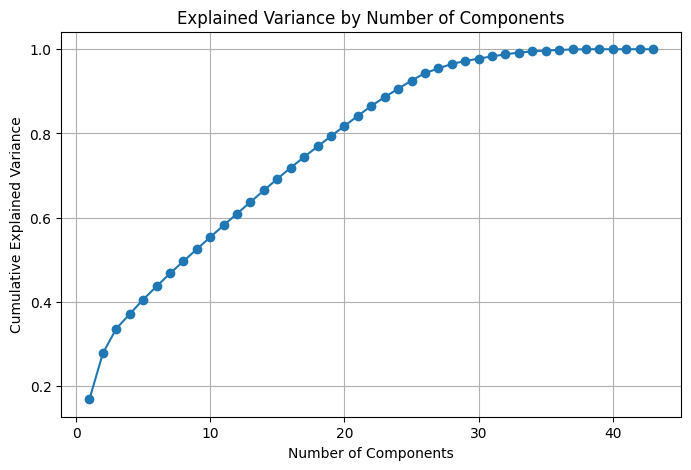

In [93]:
# Apply PCA
pca = PCA().fit(train[feature_cols])

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()


In [100]:
pca = PCA(n_components=26)  # Reduce to 19 components
X_pca = pca.fit_transform(train[feature_cols])
X_pca = pd.DataFrame(X_pca, columns=[f'PC_{i}' for i in range(1, X_pca.shape[1] + 1)])

test_pca = pca.transform(test[feature_cols])
test_pca = pd.DataFrame(test_pca, columns=[f'PC_{i}' for i in range(1, test_pca.shape[1] + 1)])

train = pd.concat([train, X_pca], axis=1)
test = pd.concat([test, test_pca], axis=1)

### CB Model

In [101]:

X = None 
y = None 

cb_params = {
    'iterations': [500],
    'learning_rate': [0.1],
    'depth': [4]
}

cb_model = cb.CatBoostRegressor(verbose=0, random_state=42, loss_function='RMSE')


# Grid search setups
def run_grid_search(model, params, name, scoring='neg_root_mean_squared_error', X=X, y=y):
    grid = GridSearchCV(model, params, cv=3, scoring=scoring, n_jobs=-1)
    grid.fit(X, y)
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best score for {name}: {-grid.best_score_}")
    return grid.best_estimator_


In [ ]:
X = X_pca#train[feature_cols]#
y = train['price']
best_cb = run_grid_search(cb_model, cb_params, "CatBoost", X=X, y=y)


Best parameters for CatBoost: {'depth': 4, 'iterations': 500, 'learning_rate': 0.1}
Best score for CatBoost: 38.764955479905815


: 

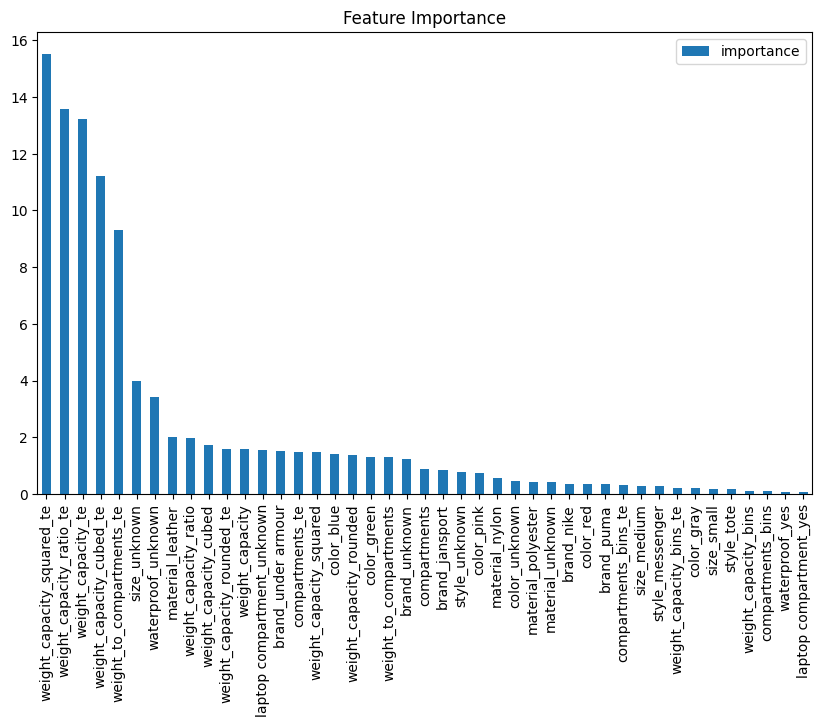

In [96]:
# plot feature importance of cat boost regressor

feature_importances = pd.DataFrame(best_cb.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)

feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()

In [97]:
test['price'] = best_cb.predict(test[X.columns])

In [98]:
def create_submission_file(sub_df):
    submission = sub_df[['id', 'price']]
    submission = submission.rename(columns={'price': 'Price'})
    print(submission.isna().sum().sum())
    display(submission.head())
    file_name = datetime.now().strftime('submissions/submission_%Y%m%d_%H%M.csv')
    submission.to_csv(file_name, index = False)

In [99]:
create_submission_file(test)

0


,id,Price
0,300000,81.114782
1,300001,82.929185
2,300002,88.517817
3,300003,77.156247
4,300004,79.833510
